In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('white')
%matplotlib inline

In [2]:
events = pandas.read_csv('events.csv')
events.columns

Index(['id_odsp', 'id_event', 'sort_order', 'time', 'text', 'event_type',
       'event_type2', 'side', 'event_team', 'opponent', 'player', 'player2',
       'player_in', 'player_out', 'shot_place', 'shot_outcome', 'is_goal',
       'location', 'bodypart', 'assist_method', 'situation', 'fast_break'],
      dtype='object')

## get the winner of each game

In [3]:
## get the number of goals each side scored

#number of goals from the home side
home_side_goals = pandas.DataFrame({'final_num_goals_home' : events[events['is_goal']==1][events['side']==1].groupby('id_odsp').size()})
home_side_goals.reset_index(inplace = True)

#number of goals from the away side
away_side_goals = pandas.DataFrame({'final_num_goals_away' : events[events['is_goal']==1][events['side']==2].groupby('id_odsp').size()})
away_side_goals.reset_index(inplace = True)

#merge the two on the game id
num_goals = pandas.merge(home_side_goals, away_side_goals, on='id_odsp', how='outer') ##left join so that we 
num_goals.fillna(0, inplace = True)
num_goals.head()

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,id_odsp,final_num_goals_home,final_num_goals_away
0,00LMl81F/,2.0,3.0
1,00QH2XdM/,3.0,2.0
2,00QL4t1L/,2.0,0.0
3,00WAhrVe/,3.0,1.0
4,00Wld37M/,2.0,0.0


In [4]:
def get_winner(n_home, n_away): ##get two numbers and return 0 if draw or the winning side
    if n_home == n_away:
        return 0
    elif n_home < n_away: #if the away team won
        return 2
    else:
        return 1

num_goals['winner'] = num_goals.apply(lambda x: get_winner(x['final_num_goals_home'], x['final_num_goals_away']), axis = 1)
num_goals.head()

,id_odsp,final_num_goals_home,final_num_goals_away,winner
0,00LMl81F/,2.0,3.0,2
1,00QH2XdM/,3.0,2.0,1
2,00QL4t1L/,2.0,0.0,1
3,00WAhrVe/,3.0,1.0,1
4,00Wld37M/,2.0,0.0,1


## get the biggest lead in the game

### get all the goals scored in order

In [5]:
all_goals = events[events['is_goal']==1].sort_values(by= ['id_odsp','time'])[['id_odsp','time','side']]
all_goals.reset_index(inplace = True)
del all_goals['index']
all_goals.head()

,id_odsp,time,side
0,004f4ING/,82,2
1,00LMl81F/,17,2
2,00LMl81F/,28,1
3,00LMl81F/,30,2
4,00LMl81F/,78,2


### go through all the goals and update the scoreboard

In [6]:
goals_side_1 = []
goals_side_2 = []

current_game = None


for i in range(len(all_goals)):
    game = all_goals['id_odsp'][i]
    side = all_goals['side'][i]
    
    if game == current_game:
        if side == 1:
            goals_side_1.append(goals_side_1[i-1]+1)
            goals_side_2.append(goals_side_2[i-1])
        else:
            goals_side_1.append(goals_side_1[i-1])
            goals_side_2.append(goals_side_2[i-1]+1)
    else:
        current_game = game
        if side == 1:
            goals_side_1.append(1)
            goals_side_2.append(0)
        else:
            goals_side_1.append(0)
            goals_side_2.append(1)

In [7]:
len(goals_side_1), len(goals_side_2), len(all_goals)

(24446, 24446, 24446)

In [8]:
all_goals['goals_side_1'] = goals_side_1
all_goals['goals_side_2'] = goals_side_2

### join the scoreboard df with the final winner df

In [9]:
df = pandas.merge(all_goals, num_goals, on ='id_odsp', how='inner')

### number of games that had at one point each observed scoreline

In [10]:
num_games = df.groupby(['goals_side_1', 'goals_side_2']).size().to_frame().reset_index().rename(columns = {0 : 'num_games'})
print('There are %s unique scorelines' %len(num_games))
num_games.head()

There are 57 unique scorelines


,goals_side_1,goals_side_2,num_games
0,0,1,3485
1,0,2,1304
2,0,3,451
3,0,4,139
4,0,5,44


### number of each eventual result for each scoreline

In [11]:
result_dist = pandas.DataFrame(columns = ['goals_side_1', 'goals_side_2','draws', 'wins_side_1', 'wins_side_2'])

for i in range(len(num_games)):
    goals_side_1 = num_games['goals_side_1'][i]
    goals_side_2 = num_games['goals_side_2'][i]
    
    temp = df[df['goals_side_1'] == goals_side_1][df['goals_side_2'] == goals_side_2]
    
    num_draws = 0
    num_win_side_1 = 0
    num_win_side_2 = 0
    
    for winner in temp['winner']:
        if winner == 0:
            num_draws += 1
        elif winner == 1:
            num_win_side_1 += 1
        else:
            num_win_side_2 += 1
    result_dist.loc[len(result_dist)] = [goals_side_1, goals_side_2, num_draws, num_win_side_1, num_win_side_2]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [12]:
result_dist['num_games_test'] = result_dist['draws'] + result_dist['wins_side_1'] + result_dist['wins_side_2']

### merge the result distribution with the num_games df

In [13]:
final_df = pandas.merge(num_games, result_dist, on = ['goals_side_1', 'goals_side_2'], how = 'inner')
print( sum(final_df['num_games'] == final_df['num_games_test']) == len(final_df))
final_df.head()

True


,goals_side_1,goals_side_2,num_games,draws,wins_side_1,wins_side_2,num_games_test
0,0,1,3485,761,566,2158,3485
1,0,2,1304,101,31,1172,1304
2,0,3,451,7,0,444,451
3,0,4,139,0,0,139,139
4,0,5,44,0,0,44,44


### add a column for the lead

In [14]:
# positive number indicates that the home side is winning
# negative number indicates that the away side is winning

final_df['lead'] = final_df['goals_side_1'] - final_df['goals_side_2']

#### number of games that at some point had each scoreline

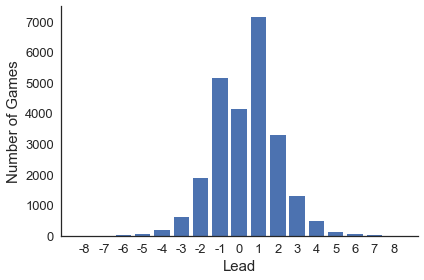

In [15]:
t = final_df.groupby('lead')['num_games'].sum()
plt.xticks(t.index, t.index)
plt.tick_params(labelsize = 13)
plt.xlabel('Lead', fontsize = 15)
plt.ylabel('Number of Games', fontsize = 15)
plt.bar(t.index, t)
plt.tight_layout()
seaborn.despine()

## Analysis

### number of draws for each lead

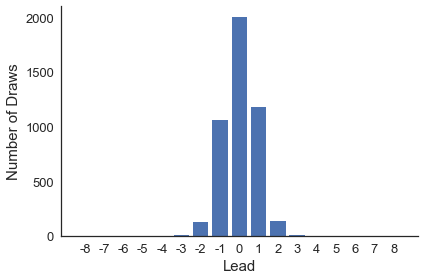

In [16]:
draws = final_df.groupby('lead')['draws'].sum()

plt.xticks(draws.index, draws.index)
plt.tick_params(labelsize = 13)
plt.xlabel('Lead', fontsize = 15)
plt.ylabel('Number of Draws', fontsize = 15)
plt.bar(draws.index, draws)
plt.tight_layout()
seaborn.despine()

### number of home wins for each lead

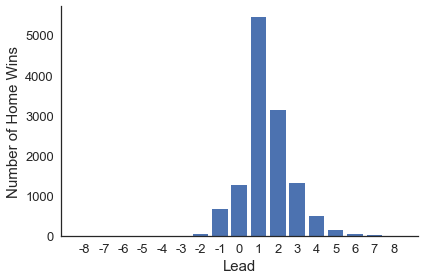

In [17]:
home_wins = final_df.groupby('lead')['wins_side_1'].sum()

plt.xticks(home_wins.index, home_wins.index)
plt.tick_params(labelsize = 13)
plt.xlabel('Lead', fontsize = 15)
plt.ylabel('Number of Home Wins', fontsize = 15)
plt.bar(home_wins.index, home_wins)
plt.tight_layout()
seaborn.despine()

We see that the number of home wins is higher when the lead is positive, i.e., when the home team is leading

### number of away wins for each lead

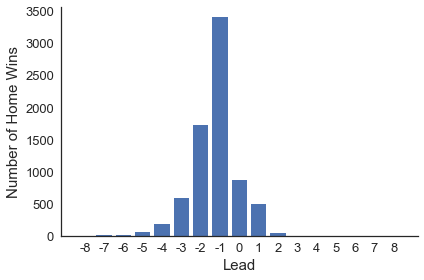

In [18]:
away_wins = final_df.groupby('lead')['wins_side_2'].sum()

plt.xticks(away_wins.index, away_wins.index)
plt.tick_params(labelsize = 13)
plt.xlabel('Lead', fontsize = 15)
plt.ylabel('Number of Home Wins', fontsize = 15)
plt.bar(away_wins.index, away_wins)
plt.tight_layout()
seaborn.despine()

We see that the number of away wins is higher when the lead is negative, i.e., when the away team is leading

## get the result distributions as a function of the lead

In [19]:
df['lead'] = df['goals_side_1'] - df['goals_side_2']

In [20]:
results = []
for i in range(len(df)):
    if (df['lead'][i]<0 and df['winner'][i] == 2) or (df['lead'][i]>0 and df['winner'][i]==1):
        results.append('win')
    elif (df['lead'][i]<0 and df['winner'][i] == 1) or (df['lead'][i]>0 and df['winner'][i]==2):
        results.append('lose')
    elif df['lead'][i] == 0:
        results.append(df['winner'][i])
    else:
        results.append('draw')

df['final_result'] = results

For this analysis I ignore tied scorelines, aka leads of 0

In [21]:
df['lead_abs'] = abs(df['lead'])

In [22]:
df[df['lead_abs']>0].groupby(['lead_abs']).size()

lead_abs
1    12261
2     5187
3     1919
4      661
5      192
6       59
7       24
8       10
dtype: int64

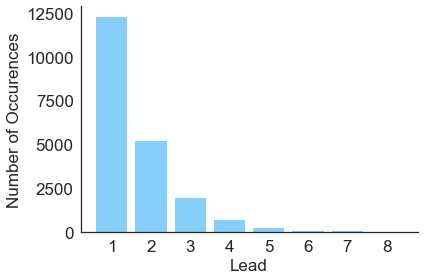

In [23]:
plt.bar(range(1,9), df[df['lead_abs']>0].groupby(['lead_abs']).size() , color='lightskyblue')


plt.xticks(range(1,9), range(1,9))
plt.tick_params(labelsize = 17)
plt.xlabel('Lead', fontsize = 17)
plt.ylabel('Number of Occurences', fontsize = 17)

plt.tight_layout()
seaborn.despine()
plt.savefig('lead_num_occurences.png', dpi=200, frameon=False)

In [24]:
df[df['lead_abs']>0].groupby(['lead_abs','final_result']).size()/df[df['lead_abs']>0].groupby(['lead_abs']).size()*100

lead_abs  final_result
1         draw             18.301933
          lose              9.575075
          win              72.122992
2         draw              4.993252
          lose              1.426644
          win              93.580104
3         draw              0.833768
          lose              0.052110
          win              99.114122
4         win             100.000000
5         win             100.000000
6         win             100.000000
7         win             100.000000
8         win             100.000000
dtype: float64

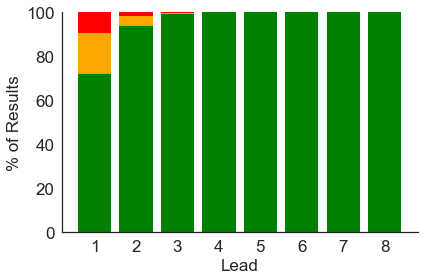

In [25]:
win = [72.12, 93.58, 99.11, 100, 100, 100, 100,100]
lose = [9.57, 1.42, 0.052, 0, 0, 0, 0, 0]
draw = [18.3, 4.99, 0.83, 0, 0, 0, 0, 0]

plt.bar(range(1,9), win , color='g')
plt.bar(range(1,9), draw , bottom = win,  color='orange')
plt.bar(range(1,9), lose, bottom = [x + y for x, y in zip(win, draw)], color = 'red' )


plt.xticks(range(1,9), range(1,9))
plt.tick_params(labelsize = 17)
plt.xlabel('Lead', fontsize = 17)
plt.ylabel('% of Results', fontsize = 17)

plt.tight_layout()
seaborn.despine()
plt.savefig('lead_num_occurences.png', dpi=200, frameon=False)

## consider only 2-0 (or 0-2) leads and compared them with 1-0 (0-1)

In [26]:
## 1-0 or 0-1 leads and all the final resutls
df[df['goals_side_1']==0][df['goals_side_2']==1].groupby('final_result').size()+\
df[df['goals_side_1']==1][df['goals_side_2']==0].groupby('final_result').size()

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


final_result
draw    1595
lose     984
win     5781
dtype: int64

In [27]:
## 2-0 or 0-2 leads and all the final resutls
df[df['goals_side_1']==0][df['goals_side_2']==2].groupby('final_result').size()+\
df[df['goals_side_1']==2][df['goals_side_2']==0].groupby('final_result').size()

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


final_result
draw     209
lose      62
win     3357
dtype: int64

In [28]:
## 3-0 or 0-3 leads and all the final resutls
df[df['goals_side_1']==0][df['goals_side_2']==3].groupby('final_result').size() + \
df[df['goals_side_1']==3][df['goals_side_2']==0].groupby('final_result').size()

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


final_result
draw      13.0
lose       NaN
win     1396.0
dtype: float64

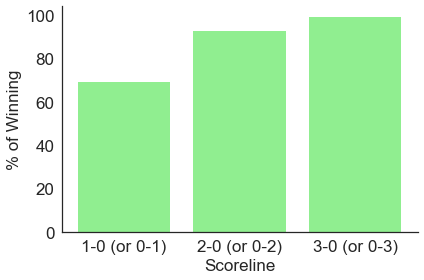

In [29]:
plt.bar(range(3), [5781/(1595+984+5781)*100, 3357/(209+62+3357)*100, 1396.0/(1+13.0+1396.0)*100] , color='lightgreen')


plt.xticks(range(3), ['1-0 (or 0-1)', '2-0 (or 0-2)' ,'3-0 (or 0-3)'])
plt.tick_params(labelsize = 17)
plt.xlabel('Scoreline', fontsize = 17)
plt.ylabel('% of Winning', fontsize = 17)

plt.tight_layout()
seaborn.despine()
plt.savefig('two_null_leads.png', dpi=200, frameon=False)